In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from phylo_gnn import get_data_path
from phylo_gnn.encoding import VectorTree

In [3]:
df = pd.read_csv(get_data_path() / "raw" / "489_10k_nwk.csv")

In [4]:
# Sample a subset of the data
df = df.sample(2000, random_state=42)

In [5]:
vector_trees = [
    VectorTree.from_newick(row["nwk"])
    for _, row in tqdm.tqdm(
        df.iterrows(), total=len(df), desc="Encoding trees"
    )
]

Encoding trees: 100%|██████████| 2000/2000 [00:17<00:00, 113.82it/s]


In [8]:
avg_branch_lengths = np.array(
    [np.mean(tree.branch_lengths) for tree in vector_trees],
)

In [9]:
# add "rescale_factor" column to the dataframe
df["rescale_factor"] = avg_branch_lengths

In [10]:
df

,nwk,label,rescale_factor
0,"((((((((197:0.944288,(311:0.821147,312:0.82114...",0,0.998082
1,"(((((31:6.62518,((105:4.91516,((275:0.643727,2...",0,0.999762
2,"((((((((((((((((919:0.545101,(955:0.455584,956...",0,0.998971
3,"((((((43:0.899426,(79:0.727872,80:0.727872)44:...",0,0.994622
4,"(((((((109:0.774441,(183:0.535652,184:0.535652...",0,0.993369
...,...,...,...
59995,"((((15:5.18239,(((((((((((871:0.424783,(927:0....",5,0.999397
59996,"((((((((((((((715:0.317609,716:0.317609)621:0....",5,0.999986
59997,"((((((((((((667:0.709392,(783:0.521597,784:0.5...",5,0.998866
59998,"((((((((93:0.350582,94:0.350582)59:3.8663,60:4...",5,0.999413


In [11]:
df_without_nwk = df.drop(columns=["nwk"])
# group by "label" and aggregate the "rescale_factor" column
# with mean, std, min, and max
grouped_df = df_without_nwk.groupby("label").aggregate(
    {"rescale_factor": ["mean", "std", "min", "max", "count"]}
)
grouped_df

rescale_factor                                
                mean       std       min  max  count
label                                               
0           0.997582  0.002415  0.979517  1.0  10000
1           0.993836  0.006266  0.930751  1.0  10000
2           0.996994  0.003101  0.969564  1.0  10000
3           0.999688  0.000322  0.996298  1.0  10000
4           0.975819  0.035138  0.538054  1.0  10000
5           0.999677  0.000400  0.993599  1.0  10000

In [38]:
def get_height(tree: VectorTree):
    return np.max(tree.distance_to_root)


tree_heights = np.array(
    [get_height(tree) for tree in tqdm.tqdm(vector_trees)],
)

100%|██████████| 2000/2000 [00:00<00:00, 2580.18it/s]


In [37]:
min_branch_lengths = np.array(
    [np.min(tree.branch_lengths[1:]) for tree in vector_trees],
)
max_branch_lengths = np.array(
    [np.max(tree.branch_lengths) for tree in vector_trees],
)
std_branch_lengths = np.array(
    [np.std(tree.branch_lengths) for tree in vector_trees],
)
# add "min_branch_length", "max_branch_length", and "std_branch_length" columns to the dataframe
df["min_branch_length"] = min_branch_lengths
df["max_branch_length"] = max_branch_lengths
df["std_branch_length"] = std_branch_lengths
df["tree_height"] = tree_heights

(df["min_branch_length"] / 10).describe()

count    6.000000e+04
mean     9.155913e-05
std      1.003558e-04
min     -8.230610e-08
25%      2.368020e-05
50%      5.931850e-05
75%      1.237698e-04
max      1.345060e-03
Name: min_branch_length, dtype: float64

In [ ]:
# Escale the branch lengths with a log transformation (sklearn)
from sklearn.preprocessing import FunctionTransformer

scaler = FunctionTransformer(func=np.lolog1g1p, validate=True)
branch_lengths = np.concat(
    [tree.branch_lengths.reshape(1, -1) for tree in vector_trees],
)
branch_lengths.shape

(2000, 977)

In [31]:
scaled_branch_lengths = scaler.fit_transform(branch_lengths)

In [33]:
# add "scaled_branch_length_max" column to the dataframe
df["scaled_branch_length_max"] = scaled_branch_lengths.max(axis=1)
df["scaled_branch_length_min"] = scaled_branch_lengths[:,1:].min(axis=1)
df["scaled_branch_length_std"] = scaled_branch_lengths.std(axis=1)

scaled_grouped_df = df.groupby("label").aggregate(
    {
        "scaled_branch_length_max": ["mean", "std", "min", "max"],
        "scaled_branch_length_min": ["mean", "std", "min", "max"],
        "scaled_branch_length_std": ["mean", "std", "min", "max"],
    }
)
scaled_grouped_df

scaled_branch_length_max                                \
                          mean       std       min       max   
label                                                          
0                     2.192738  0.152829  1.895496  2.684256   
1                     2.721670  0.210443  2.223814  3.337768   
2                     2.574619  0.213329  2.044167  3.186762   
3                     1.388464  0.067164  1.238566  1.670228   
4                     3.142331  0.579252  1.978149  5.172811   
5                     1.622487  0.158104  1.285559  2.086499   

      scaled_branch_length_min                                    \
                          mean       std           min       max   
label                                                              
0                     0.001351  0.001317  2.861016e-06  0.009557   
1                     0.000870  0.000917  1.907348e-06  0.005525   
2                     0.001007  0.001005  3.379634e-06  0.007243   
3                     0.000633  0.000642  1.251699e-06  0.004672   
4                     0.001213  0.001184  1.291699e-06  0.005772   
5                     0.000576  0.000649  6.556508e-07  0.004375   

      scaled_branch_length_std                                
                          mean       std       min       max  
label                                                         
0                     0.430847  0.011112  0.399034  0.458953  
1                     0.490678  0.011601  0.464680  0.526331  
2                     0.467208  0.020680  0.422168  0.540415  
3                     0.415309  0.013682  0.385713  0.460562  
4                     0.449642  0.032581  0.375030  0.592681  
5                     0.488219  0.033068  0.406264  0.569298

In [35]:
grouped_df = df.groupby("label").aggregate(
    {
        "max_branch_length": ["mean", "std", "min", "max"],
        "std_branch_length": ["mean", "std", "min", "max"],
        "tree_height": ["mean", "std", "min", "max"],
    }
)

grouped_df

max_branch_length                                 std_branch_length  \
                   mean        std      min         max              mean   
label                                                                       
0              8.165362   1.594377  4.54500   20.630899          1.054209   
1             14.868283   3.821575  7.16179   46.442200          1.484789   
2             12.396483   3.360038  5.60985   38.214901          1.330792   
3              3.005793   0.267044  2.36945    4.723020          0.796897   
4             27.204599  20.163805  5.63786  210.860992          1.794919   
5              4.063900   0.847932  2.37807    8.485890          1.089216   

                                    tree_height                        \
            std       min       max        mean        std        min   
label                                                                   
0      0.057642  0.889318  1.364458   12.819531   2.009009   8.090905   
1      0.127316  1.125765  2.209331   23.449371   4.677061  12.857011   
2      0.159710  0.959525  2.062661   18.767075   4.305552   8.226814   
3      0.019512  0.730614  0.887950    3.749509   0.386545   2.703843   
4      0.862191  0.831589  9.245891   37.941689  22.147055   9.682446   
5      0.162684  0.748794  1.731297    4.863597   1.017846   2.678576   

                   
              max  
label              
0       25.937410  
1       51.341766  
2       43.129726  
3        6.144970  
4      216.461655  
5       11.782441

In [ ]:
# divide max_branch_length. tree_height.max

In [13]:
X = df[["max_branch_length", "std_branch_length"]]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [28]:
y_pred = rf.predict(X_test)
LABEL_NAMES = ["BD", "HE", "ME", "SAT", "SR", "WW"]
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))

              precision    recall  f1-score   support

          BD       0.80      0.87      0.83      1494
          HE       0.64      0.72      0.67      1475
          ME       0.56      0.52      0.54      1476
         SAT       0.99      0.99      0.99      1554
          SR       0.77      0.66      0.71      1491
          WW       0.98      0.99      0.99      1510

    accuracy                           0.79      9000
   macro avg       0.79      0.79      0.79      9000
weighted avg       0.79      0.79      0.79      9000



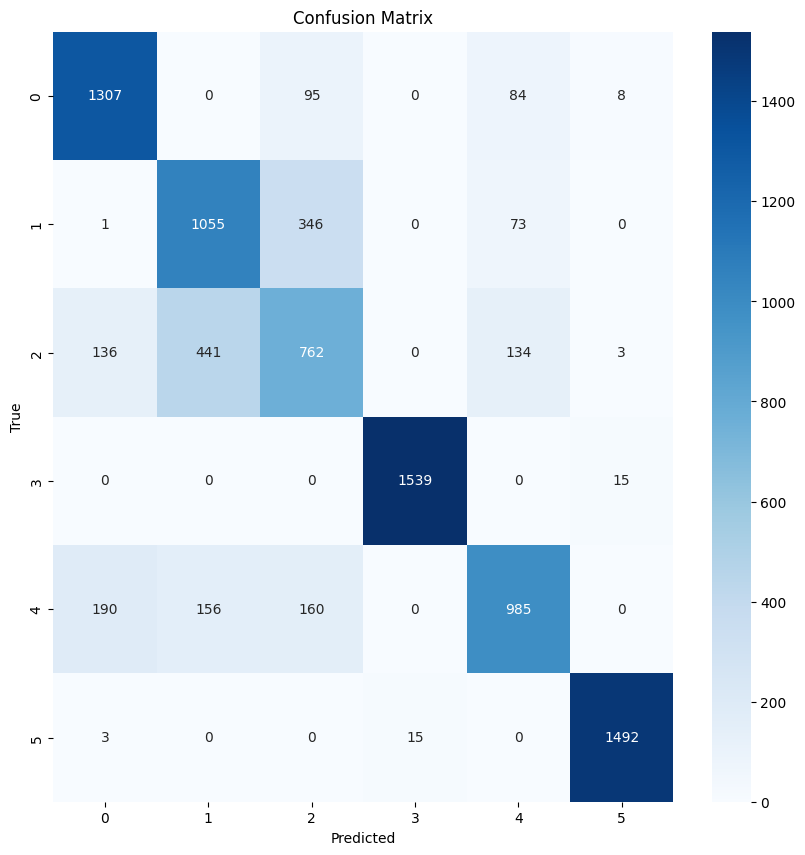

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

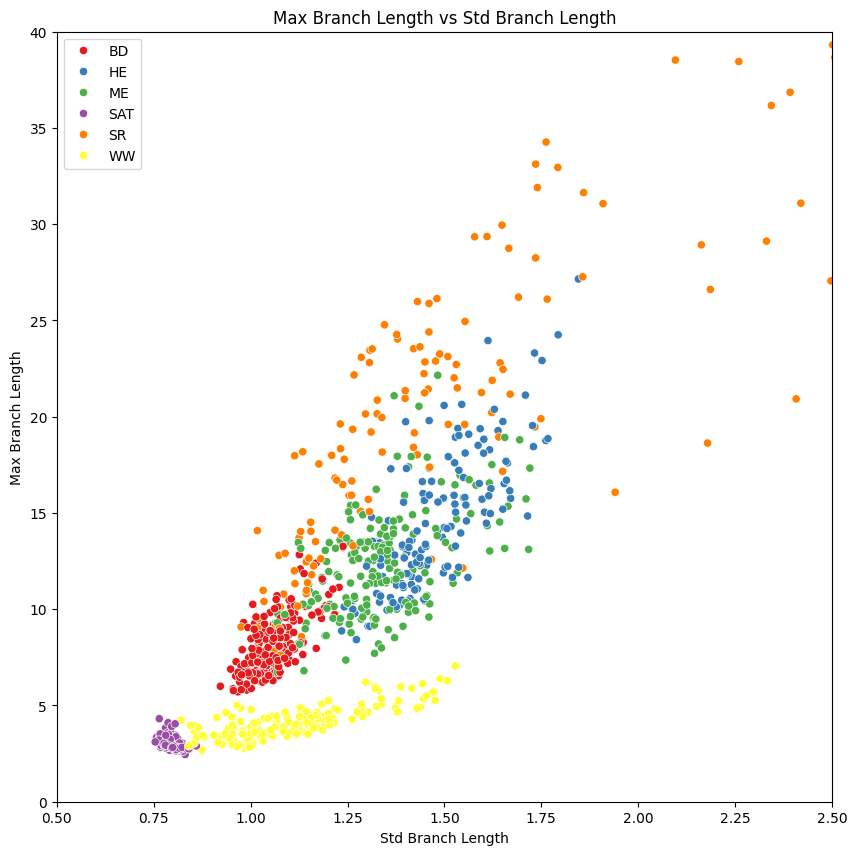

In [ ]:
# plot in the x axis the max branch length and in the y axis the std branch length
# and color the points by the label


# Assuming df has numeric labels from 0-5, create a copy and map the integers to names
plot_df = df.copy().sample(1000, random_state=42)
plot_df["label_name"] = plot_df["label"].map(lambda x: LABEL_NAMES[x])
# sort by the label name
plot_df["label_name"] = pd.Categorical(
    plot_df["label_name"], categories=LABEL_NAMES, ordered=True
)

# Create the plot
plt.figure(figsize=(10, 10))
sns.scatterplot(
    y="max_branch_length",
    x="std_branch_length",
    hue="label_name",  # Use the text labels instead of integers
    data=plot_df,
    palette="Set1",
)
plt.title("Max Branch Length vs Std Branch Length")
plt.xlabel("Std Branch Length")
plt.ylabel("Max Branch Length")
plt.legend(loc="upper left")
# x limit from 0 to 2.5
plt.xlim(0.5, 2.5)
# y limit from 0 to 50
plt.ylim(0, 40)

# save the figure
plt.savefig(
    get_data_path().parent / "images" / "max_std_branch_length.png", dpi=300
)
plt.show()

In [36]:
X_scaled = df[["scaled_branch_length_max", "scaled_branch_length_std"]]
y_scaled = df["label"]
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.15, random_state=42
)
rf_scaled = RandomForestClassifier(n_estimators=500, random_state=42)
rf_scaled.fit(X_train_scaled, y_train_scaled)

RandomForestClassifier(n_estimators=500, random_state=42)

In [37]:
y_pred_scaled = rf_scaled.predict(X_test_scaled)
LABEL_NAMES = ["BD", "HE", "ME", "SAT", "SR", "WW"]
print(classification_report(y_test_scaled, y_pred_scaled, target_names=LABEL_NAMES))

              precision    recall  f1-score   support

          BD       0.76      0.85      0.80        46
          HE       0.84      0.71      0.77        51
          ME       0.57      0.71      0.63        41
         SAT       0.97      0.97      0.97        58
          SR       0.81      0.70      0.75        50
          WW       0.96      0.96      0.96        54

    accuracy                           0.82       300
   macro avg       0.82      0.81      0.81       300
weighted avg       0.83      0.82      0.83       300



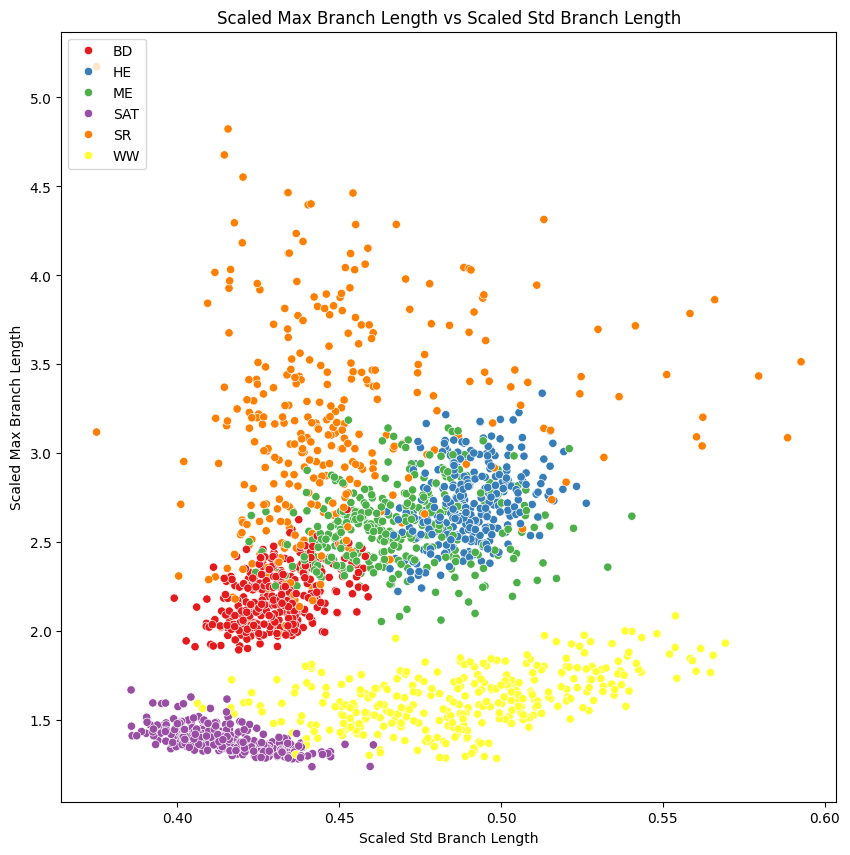

In [35]:
plot_df_scaled = df.copy()
plot_df_scaled["label_name"] = plot_df_scaled["label"].map(
    lambda x: LABEL_NAMES[x]
)
# sort by the label name
plot_df_scaled["label_name"] = pd.Categorical(
    plot_df_scaled["label_name"], categories=LABEL_NAMES, ordered=True
)
# Create the plot
plt.figure(figsize=(10, 10))
sns.scatterplot(
    y="scaled_branch_length_max",
    x="scaled_branch_length_std",
    hue="label_name",  # Use the text labels instead of integers
    data=plot_df_scaled,
    palette="Set1",
)
plt.title("Scaled Max Branch Length vs Scaled Std Branch Length")
plt.xlabel("Scaled Std Branch Length")
plt.ylabel("Scaled Max Branch Length")
plt.legend(loc="upper left")
plt.savefig(
    get_data_path().parent / "images" / "scaled_max_std_branch_length.png", dpi=300
)
plt.show()

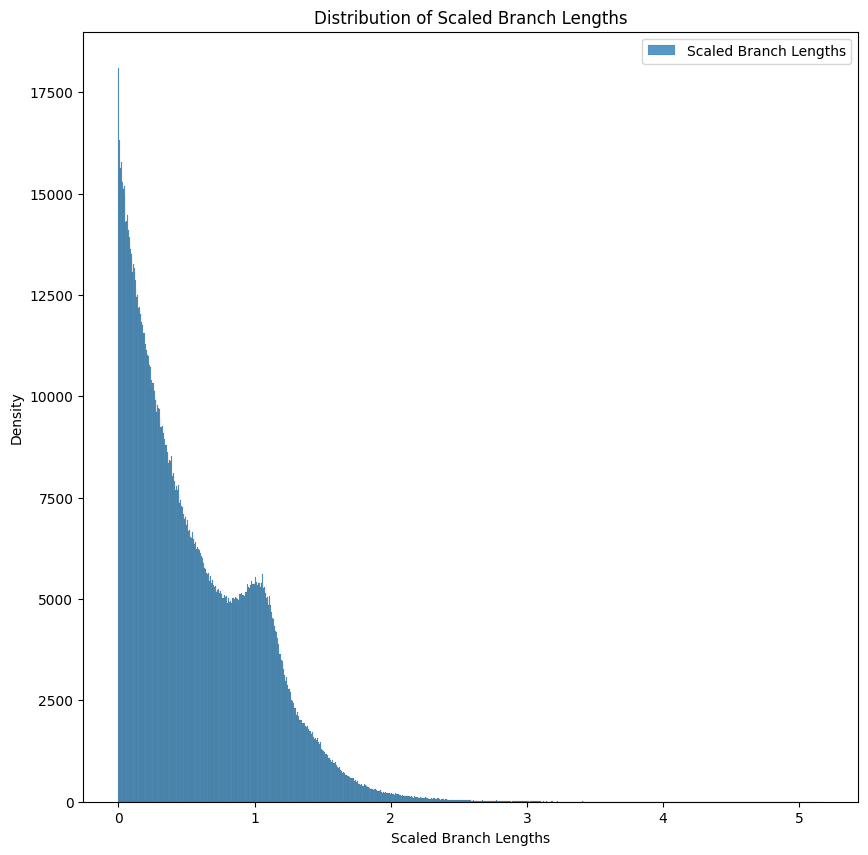

In [34]:
# plot distribution of the scaled branch lengths
plt.figure(figsize=(10, 10))
sns.histplot(
    data=scaled_branch_lengths.reshape(-1),
    bins=1000,
    label="Scaled Branch Lengths",
)
plt.title("Distribution of Scaled Branch Lengths")
plt.xlabel("Scaled Branch Lengths")
plt.ylabel("Density")
plt.legend()
plt.show()

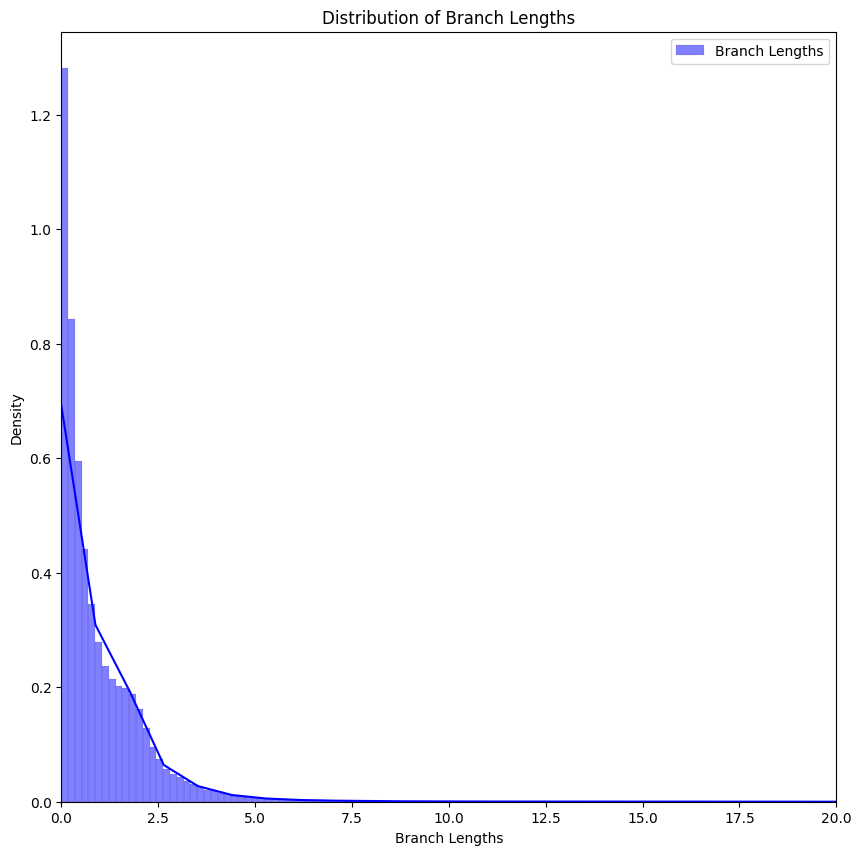

In [25]:
plt.figure(figsize=(10, 10))
sns.histplot(
    data=branch_lengths.reshape(-1),
    bins=1000,
    stat="density",
    color="blue",
    kde=True,
    label="Branch Lengths",
)
plt.title("Distribution of Branch Lengths")
plt.xlabel("Branch Lengths")
plt.ylabel("Density")
plt.legend()
plt.xlim(0, 20)
plt.show()

Text(0.5, 1.0, 'Distribution of Tree Heights')

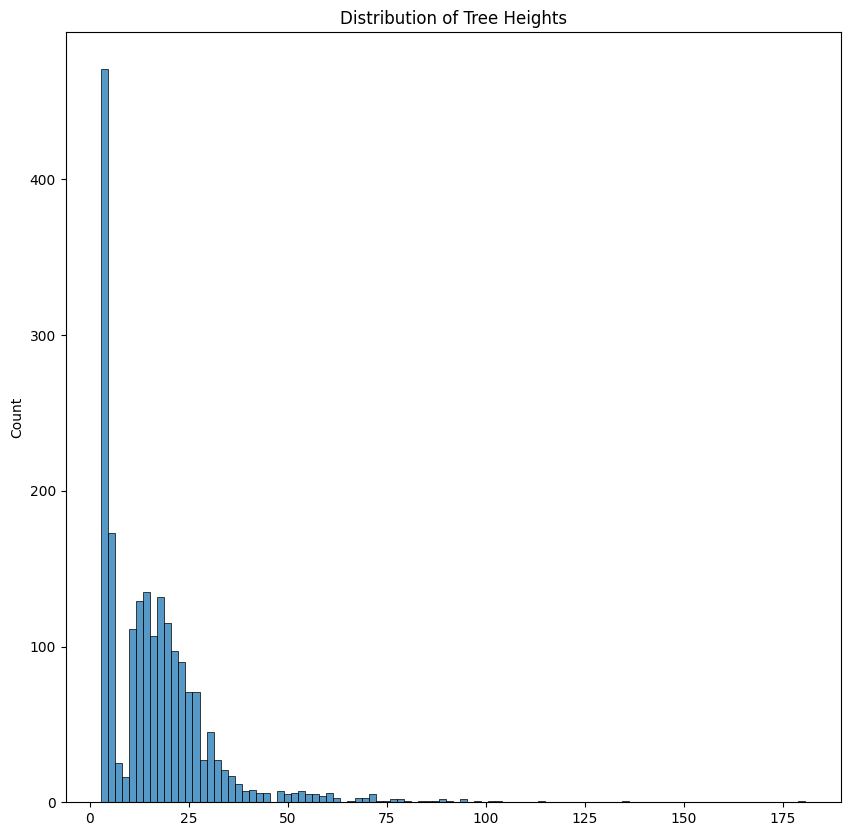

In [39]:
# plot tree heights distributions
plt.figure(figsize=(10, 10))
sns.histplot(
    data=tree_heights,
    bins=100,
    label="Tree Heights",
)
plt.title("Distribution of Tree Heights")